In [2]:
!if [ ! -e /data/home/vadim/abalone.data ]; then wget http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data -O /data/home/vadim/abalone.data; fi

--2018-08-05 08:56:49--  http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 191873 (187K) [text/plain]
Saving to: ‘/data/home/vadim/abalone.data’

/data/home/vadim/ab 100%[===================>] 187.38K   160KB/s    in 1.2s    

2018-08-05 08:56:51 (160 KB/s) - ‘/data/home/vadim/abalone.data’ saved [191873/191873]



In [4]:
%pylab inline
import pandas
column_names = ["sex", "length", "diameter", "height", "whole weight", 
                "shucked weight", "viscera weight", "shell weight", "rings"]
data = pandas.read_csv("/data/home/vadim/abalone.data", names=column_names)
print("Number of samples: %d" % len(data))
for label in "MFI":
    data[label] = data["sex"] == label
del data["sex"]
import numpy as np
from sklearn import model_selection, tree

Y = data.rings.values
del data["rings"] # remove rings from data, so we can convert all the dataframe to a numpy 2D array.
X = data.values.astype(np.float)

interval = len(Y) / 2
ymap = {}
accum = 0
i = 0
for val in range(Y.min(), Y.max() + 1):
    delta = (Y == val).sum()
    accum += delta
    if accum > interval:
        accum = delta
        i += 1
    ymap[val] = i
mapped_y = zeros(len(Y), dtype=int)
for i, v in enumerate(Y):
    mapped_y[i] = ymap[v]
Y = mapped_y
train_x, test_x, train_y, test_y = model_selection.train_test_split(X, Y) # splits 75%/25% by default
from sklearn.ensemble import RandomForestClassifier

Populating the interactive namespace from numpy and matplotlib
Number of samples: 4177


In [5]:
model = RandomForestClassifier(n_estimators=15, max_features=8, min_samples_leaf=26)
model.fit(train_x, train_y)
model.score(test_x, test_y)

0.738755980861244

In [6]:
def tree_to_rules(tree, feature_names):
    from sklearn.tree import _tree as Tree
    
    tree = tree.tree_
    feature_names = [
        feature_names[i] if i != Tree.TREE_UNDEFINED else "TREE_UNDEFINED"
        for i in tree.feature
    ]
    queue = [(0, tuple())]
    rules = []
    while queue:
        node, path = queue.pop()
        if tree.feature[node] != Tree.TREE_UNDEFINED:
            name = feature_names[node]
            threshold = tree.threshold[node]
            queue.append((tree.children_left[node], path + ((name, False, threshold),)))  # <= threshold
            queue.append((tree.children_right[node], path + ((name, True, threshold),)))  # > threshold
        else:
            rules.append((path, tuple(tree.value[node][0])))
    return rules

from copy import deepcopy
from sklearn.tree._tree import TREE_LEAF, TREE_UNDEFINED

def tree_depth(tree):
    max_depth = 0
    stack = [(0,0)]
    while stack:
        node, depth = stack.pop()
        if depth > max_depth:
            max_depth = depth
        if tree.children_left[node] != TREE_LEAF:
            stack.append((tree.children_left[node], depth+1))
        if tree.children_right[node] != TREE_LEAF:
            stack.append((tree.children_right[node], depth+1))
    return max_depth

def get_parents(tree):
    parents = {x:i for i, x in enumerate(tree.children_left) if x != TREE_LEAF}
    parents.update({x:i for i, x in enumerate(tree.children_right) if x != TREE_LEAF})
    return parents

def prune(model, validation_X, validation_y, possible_score_drop=-0.02, verbose=False):
    model = deepcopy(model)
    tree = model.tree_
    curent_score = model.score(validation_X, validation_y)
    changes = True
    while changes:
        changes = False
        leafs = np.where(tree.children_left == TREE_LEAF)[0]
        parents = get_parents(tree)
        for leaf in leafs:
            if leaf not in parents:
                continue
            parent = parents[leaf]
            _child_left = model.tree_.children_left[parent]
            _child_right = model.tree_.children_right[parent]
            _feature = model.tree_.feature[parent]
            model.tree_.children_left[parent] = TREE_LEAF
            model.tree_.children_right[parent] = TREE_LEAF
            model.tree_.feature[parent] = TREE_UNDEFINED
            new_score = model.score(validation_X, validation_y)
            #print(curent_score, new_score, (new_score - curent_score) / curent_score)
            score_change = (new_score - curent_score) / curent_score
            if score_change < possible_score_drop:
                # Bad cut
                model.tree_.children_left[parent] = _child_left
                model.tree_.children_right[parent] = _child_right
                model.tree_.feature[parent] = _feature
            else:
                if verbose:
                    print("Remove {:2} and {:2} leafs. Score change: {:.3f}".format(_child_right, _child_left, score_change))
                changes = True
                break
    return model

from collections import defaultdict

def merge_rules(rules):
    new_rules = []
    for rule, freqs in rules:
        min_vals = {}
        max_vals = {}
        flags = defaultdict(int)
        for name, cmp, val in rule:
            if cmp:
                min_vals[name] = max(min_vals.get(name, val), val)
                flags[name] |= 1
            else:
                max_vals[name] = min(max_vals.get(name, val), val)
                flags[name] |= 2
        new_rule = []
        for key, bits in sorted(flags.items()):
            if bits & 2:
                new_rule.append((key, False, max_vals[key]))
            if bits & 1:
                new_rule.append((key, True, min_vals[key]))
        new_rules.append((new_rule, freqs))
    return new_rules

def compile_rules(rules, feature_names):
    findex = {k: i for i, k in enumerate(feature_names)}
    vals = defaultdict(set)
    for rule, _ in rules:
        for name, _, val in rule:
            vals[name].add(val)
    vals = {findex[name]: sorted(v) for name, v in vals.items()}
    model = {k: ([[] for v in ts] + [[]], ts, set()) for k, ts in vals.items()}
    for ri, (rule, _) in enumerate(rules):
        allnis = set(model)
        names = set()
        for name, cmp, thr in rule:
            ni = findex[name]
            allnis.discard(ni)
            ptrs, vals, _ = model[ni]
            if name not in names:
                for ptr in ptrs:
                    ptr.append(ri)
                names.add(name)
            for ptr, brdr in zip(ptrs, vals + [1<<31]):
                # brdr_{-1} < x <= brdr
                if cmp:
                    # x > thr
                    if brdr <= thr:
                        # x <= brdr <= thr < x - impossible
                        if ptr and ptr[-1] == ri:
                            ptr.pop()
                else:
                    # x <= thr
                    if brdr > thr:
                        # x <= thr < brdr
                        # x <= thr <= brdr_{-1} < x - impossible
                        if ptr and ptr[-1] == ri:
                            ptr.pop()
        for ni in allnis:
            model[ni][2].add(ri)
    return model

def eval_rules(rules, X, Y, feature_names, uncertainty="max"):
    compiled = compile_rules(rules, feature_names)
    matched = 0
    for xi, (x, y) in enumerate(zip(X, Y)):
        ris = set(range(len(rules)))
        for i, v in enumerate(x):
            try:
                ptrs, thrs, skips = compiled[i]
            except KeyError:
                continue
            possible = ptrs[searchsorted(thrs, v)]
            ris = ris.intersection(set(possible).union(skips))
        if len(ris) == 0:
            #print("no rule!")
            continue
        if len(ris) > 1:
            if uncertainty == "max":
                maxfreq = 0
                maxri = -1
                for ri in ris:
                    freqs = rules[ri][1]
                    maxfreqi = argmax(freqs)
                    if freqs[maxfreqi] > maxfreq:
                        maxfreq = freqs[maxfreqi]
                        maxri = ri
                winner = argmax(rules[maxri][1])
            elif uncertainty == "sum":
                allfreqs = zeros_like(rules[next(iter(ris))][1])
                for ri in ris:
                    allfreqs += rules[ri][1]
                winner = argmax(allfreqs)
            elif uncertainty == "conf":
                maxri = -1
                maxconf = -1
                for ri in ris:
                    freqs = rules[ri][1]
                    conf = (max(freqs) - 0.5) / sum(freqs)
                    if conf > maxconf:
                        maxconf = conf
                        maxri = ri
                winner = argmax(rules[maxri][1])
        else:
            winner = argmax(rules[next(iter(ris))][1])
        if winner == y:
            matched += 1
    return matched / len(Y)

In [7]:
from itertools import chain
rules = list(chain.from_iterable(tree_to_rules(t, data.columns) for t in model.estimators_))

In [8]:
print(eval_rules(rules, test_x, test_y, data.columns, uncertainty="sum"))
print(eval_rules(rules, test_x, test_y, data.columns, uncertainty="max"))
print(eval_rules(rules, test_x, test_y, data.columns, uncertainty="conf"))

0.738755980861244
0.7090909090909091
0.723444976076555


In [9]:
rules = merge_rules(rules)

In [10]:
import GPyOpt.methods

def get_domain(rules):
    return [{"name": "r%d" % i, "type": "categorical", "domain": (0, 1)} for i in range(len(rules))]

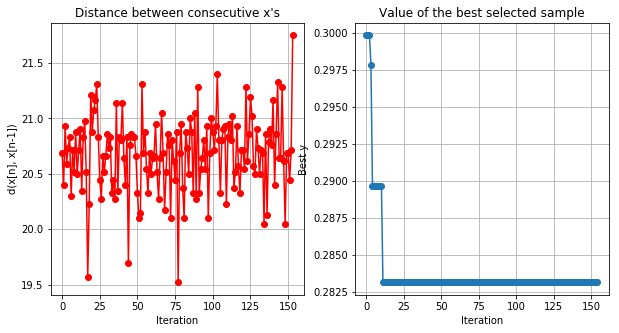

In [11]:
def fit_rules(x):
    new_rules = [r for i, r in enumerate(rules) if x[0][i]]
    return 1 - eval_rules(new_rules, test_x, test_y, data.columns, uncertainty="conf") \
        + len(new_rules) * 0.05 / len(rules)
    
opt = GPyOpt.methods.BayesianOptimization(f=fit_rules,
                                          model_type="sparseGP",
                                          domain=get_domain(rules), acquisition_type="LCB",
                                          acquisition_weight=0.5, num_cores=16)
opt.run_optimization(max_iter=150)
opt.plot_convergence()

In [14]:
best_rules = [r for i, r in enumerate(rules) if opt.X[argmin(opt.Y)][i]]
len(best_rules), eval_rules(best_rules, test_x, test_y, data.columns, uncertainty="conf")

(440, 0.7425837320574162)

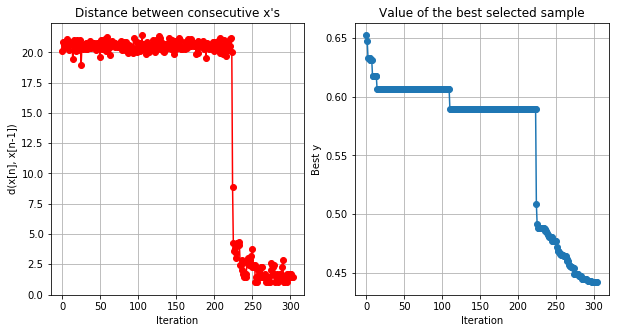

In [19]:
def fit_rules(x):
    new_rules = [r for i, r in enumerate(rules) if x[0][i]]
    return 1 - eval_rules(new_rules, test_x, test_y, data.columns, uncertainty="conf") \
        + len(new_rules) * 0.75 / len(rules)
    
opt = GPyOpt.methods.BayesianOptimization(f=fit_rules,
                                          domain=get_domain(rules), acquisition_type="LCB",
                                          acquisition_weight=0.25, num_cores=16)
opt.run_optimization(max_iter=300)
opt.plot_convergence()

In [20]:
best_rules = [r for i, r in enumerate(rules) if opt.X[argmin(opt.Y)][i]]
len(best_rules), eval_rules(best_rules, test_x, test_y, data.columns, uncertainty="conf")

(209, 0.7416267942583732)

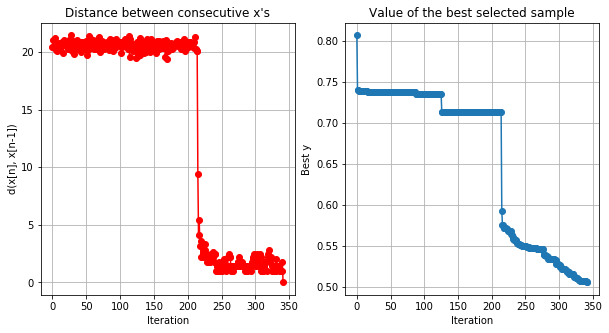

In [21]:
def fit_rules(x):
    new_rules = [r for i, r in enumerate(rules) if x[0][i]]
    return 1 - eval_rules(new_rules, test_x, test_y, data.columns, uncertainty="conf") \
        + len(new_rules) * 1.0 / len(rules)
    
opt = GPyOpt.methods.BayesianOptimization(f=fit_rules,
                                          domain=get_domain(rules), acquisition_type="LCB",
                                          acquisition_weight=0.25, num_cores=16)
opt.run_optimization(max_iter=350)
opt.plot_convergence()

In [22]:
best_rules = [r for i, r in enumerate(rules) if opt.X[argmin(opt.Y)][i]]
len(best_rules), eval_rules(best_rules, test_x, test_y, data.columns, uncertainty="conf")

(217, 0.7483253588516746)

In [28]:
def fit_rules(x):
    new_rules = [r for i, r in enumerate(rules) if x[0][i]]
    return 1 - eval_rules(new_rules, test_x, test_y, data.columns, uncertainty="conf") \
        + len(new_rules) * 1.25 / len(rules)
    
opt = GPyOpt.methods.BayesianOptimization(f=fit_rules,
                                          domain=get_domain(rules), acquisition_type="LCB",
                                          acquisition_weight=0.25, num_cores=16)

CPU times: user 16h 58min 37s, sys: 1h 29min 6s, total: 18h 27min 43s
Wall time: 1h 6min 38s


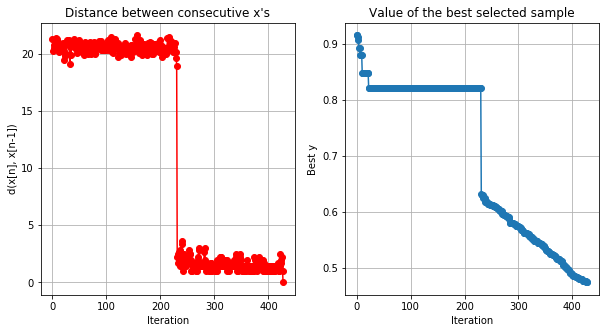

In [29]:
%time opt.run_optimization(max_iter=1000)
opt.plot_convergence()

CPU times: user 6d 22h 58min 15s, sys: 10h 21min 22s, total: 7d 9h 19min 37s
Wall time: 9h 31min 1s


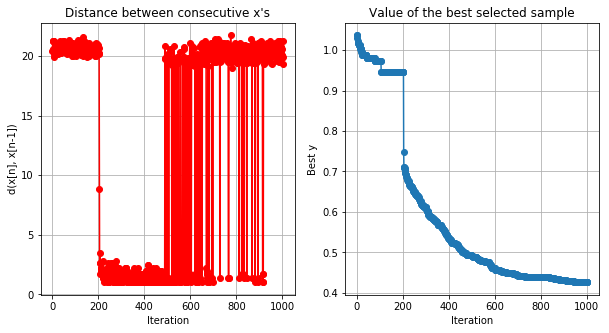

In [32]:
def fit_rules(x):
    new_rules = [r for i, r in enumerate(rules) if x[0][i]]
    return 1 - eval_rules(new_rules, test_x, test_y, data.columns, uncertainty="conf") \
        + len(new_rules) * 1.5 / len(rules)

opt = GPyOpt.methods.BayesianOptimization(f=fit_rules, de_duplication=True,
                                          domain=get_domain(rules), acquisition_type="LCB",
                                          acquisition_weight=0.25, num_cores=16)
%time opt.run_optimization(max_iter=1000)
opt.plot_convergence()

In [33]:
best_rules = [r for i, r in enumerate(rules) if opt.X[argmin(opt.Y)][i]]
len(best_rules), eval_rules(best_rules, test_x, test_y, data.columns, uncertainty="conf")

(91, 0.7339712918660287)

In [34]:
eval_rules(best_rules, train_x, train_y, data.columns, uncertainty="conf")

0.677522349936143